In [11]:
import xarray as xr
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from matplotlib.legend_handler import HandlerTuple
import matplotlib.lines as mlines

sns.set_style("whitegrid")


# Define your parameters
encodings = ["pauli_encoding"]  # "enhanced_pauli_encoding"
ansatzes = ["BasicEntangling", "SimplifiedTwoDesign", "StronglyEntangling"]
costs = ["local", "global"]
n_qubits_range = range(2, 12 + 1)
n_circuit_layers_list = [1, 2, 3, 4]
n_layers_list = [1, 5, 10, 20]
file_types = ["abs_coeffs_var", "abs_coeffs_theory"]


def construct_path(
    encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, file_type
):
    return f"../logs/{encoding}/{ansatz}_{cost}_qubits_{n_qubits:02}_circ_layers_{n_circuit_layers:02}_periodic_layers_{n_layers:02}/03000_samples/{file_type}.npy"


def load_and_pad_data(
    encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, file_type, max_length
):
    path = Path(
        construct_path(
            encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, file_type
        )
    )
    if path.exists():
        data = np.load(path)
        padded_data = np.pad(
            data, (0, max_length - len(data)), mode="constant", constant_values=np.nan
        )
        return padded_data
    else:
        return np.full(
            max_length, np.nan
        )  # Return an array of NaNs if the file does not exist


# Determine the maximum length of the arrays
max_length = 0
for combination in itertools.product(
    encodings,
    ansatzes,
    costs,
    n_qubits_range,
    n_circuit_layers_list,
    n_layers_list,
    file_types,
):
    path = Path(construct_path(*combination[:-1], combination[-1]))
    if path.exists():
        data = np.load(path)
        max_length = max(max_length, len(data))

# Create two dictionaries for storing padded data for each file type
padded_data_avg_dict = {}
padded_data_theory_dict = {}

# Iterate through combinations and file types
for combination in itertools.product(
    encodings,
    ansatzes,
    costs,
    n_qubits_range,
    n_circuit_layers_list,
    n_layers_list,
    file_types,
):
    padded_data = load_and_pad_data(*combination[:-1], combination[-1], max_length)
    if combination[-1] == "abs_coeffs_var":
        padded_data_avg_dict[combination[:-1]] = padded_data
    else:
        padded_data_theory_dict[combination[:-1]] = padded_data

# freqs range from 0 to max_freq - 1
freqs = np.arange(max_length)

# Create an empty Dataset with defined dimensions
coords = {
    "encoding": encodings,
    "ansatz": ansatzes,
    "cost": costs,
    "n_qubits": list(n_qubits_range),
    "n_circuit_layers": n_circuit_layers_list,
    "n_layers": n_layers_list,
    "freqs": freqs,
}

# Initialize the dataset with NaNs
shape = (
    len(encodings),
    len(ansatzes),
    len(costs),
    len(n_qubits_range),
    len(n_circuit_layers_list),
    len(n_layers_list),
    len(freqs),
)
initial_data = np.full(shape, np.nan)

# Initialize the dataset
var_dataset = xr.Dataset()

# Create DataArrays for each type of data and add them to the dataset
var_dataset["var_coeff"] = xr.DataArray(
    np.full(shape, np.nan), coords=coords, dims=list(coords.keys())
)
var_dataset["var_coeff_theory"] = xr.DataArray(
    np.full(shape, np.nan), coords=coords, dims=list(coords.keys())
)

# Populate the DataArrays with the padded data
for combination in itertools.product(
    encodings, ansatzes, costs, n_qubits_range, n_circuit_layers_list, n_layers_list
):
    var_dataset["var_coeff"].loc[dict(zip(list(coords.keys())[:-1], combination))] = (
        padded_data_avg_dict.get(combination, np.full(max_length, np.nan))
    )
    var_dataset["var_coeff_theory"].loc[
        dict(zip(list(coords.keys())[:-1], combination))
    ] = padded_data_theory_dict.get(combination, np.full(max_length, np.nan))

# Display the dataset
var_dataset

<xarray.Dataset>
Dimensions:           (encoding: 1, ansatz: 3, cost: 2, n_qubits: 11,
                       n_circuit_layers: 4, n_layers: 4, freqs: 16)
Coordinates:
  * encoding          (encoding) <U14 'pauli_encoding'
  * ansatz            (ansatz) <U19 'BasicEntangling' ... 'StronglyEntangling'
  * cost              (cost) <U6 'local' 'global'
  * n_qubits          (n_qubits) int64 2 3 4 5 6 7 8 9 10 11 12
  * n_circuit_layers  (n_circuit_layers) int64 1 2 3 4
  * n_layers          (n_layers) int64 1 5 10 20
  * freqs             (freqs) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    var_coeff         (encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, freqs) float64 ...
    var_coeff_theory  (encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, freqs) float64 ...

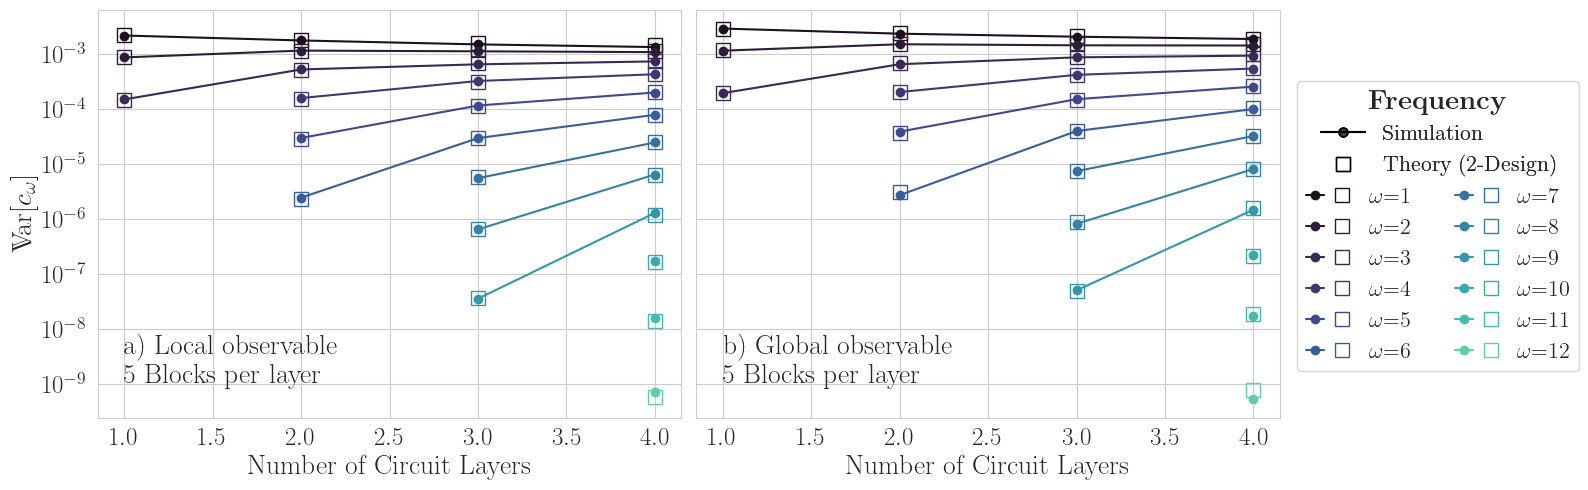

In [34]:
import matplotlib

qubits = 3
# matplotlib.use("pgf")
sns.set_style("whitegrid")
matplotlib.rcParams.update(
    {
        "pgf.preamble": (
            r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
        ),
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
)
plotting_ansatz = "StronglyEntangling"
ax_text = [
    "a) Local observable \n      5 Blocks per layer",
    "b) Global observable \n      5 Blocks per layer",
]
# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)

# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=1),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=6.5,
)
unique_theory = mlines.Line2D(
    [], [], color="k", marker="s", linestyle="", markersize=10, markerfacecolor="none"
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float("inf"), float("-inf")
i = -1
# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for row, plotting_n_layers in enumerate([5]):
    for col, cost_type in enumerate(["local", "global"]):
        ax = axs[col]
        i += 1
        for freq, color in zip(frequency_range, colors):
            # Select the appropriate data based on layer number and cost type
            data_array = var_dataset["var_coeff"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_qubits=qubits,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )
            theory_array = var_dataset["var_coeff_theory"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_qubits=qubits,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )

            # Plot the data and theory arrays
            # lines = ax.plot(data_array['n_qubits'], data_array, color=color, **plot_settings)
            # ax.plot(theory_array['n_qubits'], theory_array, color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none')
            # Check if data is above threshold before plotting
            data_above_threshold = data_array.where(data_array > 1e-28, drop=True)
            theory_above_threshold = theory_array.where(theory_array > 1e-28, drop=True)

            if data_above_threshold.size > 0:
                lines = ax.plot(
                    data_above_threshold["n_circuit_layers"],
                    data_above_threshold,
                    color=color,
                    **plot_settings
                )
            if theory_above_threshold.size > 0:
                ax.plot(
                    theory_above_threshold["n_circuit_layers"],
                    theory_above_threshold,
                    color=color,
                    marker="s",
                    linestyle="",
                    markersize=10,
                    markerfacecolor="none",
                )

            # Add legend entries only for the first row and column
            if row == 0 and col == 0:
                legend_handles.append(lines[0])
                square_handles.append(
                    mlines.Line2D(
                        [],
                        [],
                        color=color,
                        marker="s",
                        linestyle="",
                        markersize=10,
                        markerfacecolor="none",
                    )
                )
                line_sample = mlines.Line2D([], [], color=color, **plot_settings)
                legend_entries.append((line_sample, square_handles[-1]))

        # Set axis labels and scale
        if plotting_ansatz == "SimplifiedTwoDesign":
            ax.text(1, 10**-9, ax_text[i], fontsize=20)
        else:
            ax.text(1, 10**-9, ax_text[i], fontsize=20)
        ax.set_yscale("log")
        ax.tick_params(axis="both", which="major", labelsize=18)
        min_y = min(min_y, ax.get_ylim()[0])
        max_y = max(max_y, ax.get_ylim()[1])
        ax.tick_params(axis="both", which="major", labelsize=18)
        if col == 0:
            ax.set_ylabel(r"$\Var[c_\omega]$", fontsize=20)
        ax.set_xlabel("Number of Circuit Layers", fontsize=20)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 1.227, 0.85
first_legend_labels = ["Simulation", "Theory (2-Design) "]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc - 0.01, y_legend_loc - 0.068),
    fontsize=16,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"\textbf{Frequency}",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=20,
    fontsize=16,
    ncols=2,
)

first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()

plt.savefig(str(qubits)+plotting_ansatz + "_var_circ_layers.pgf", bbox_inches="tight")
# Show the plot
plt.show()

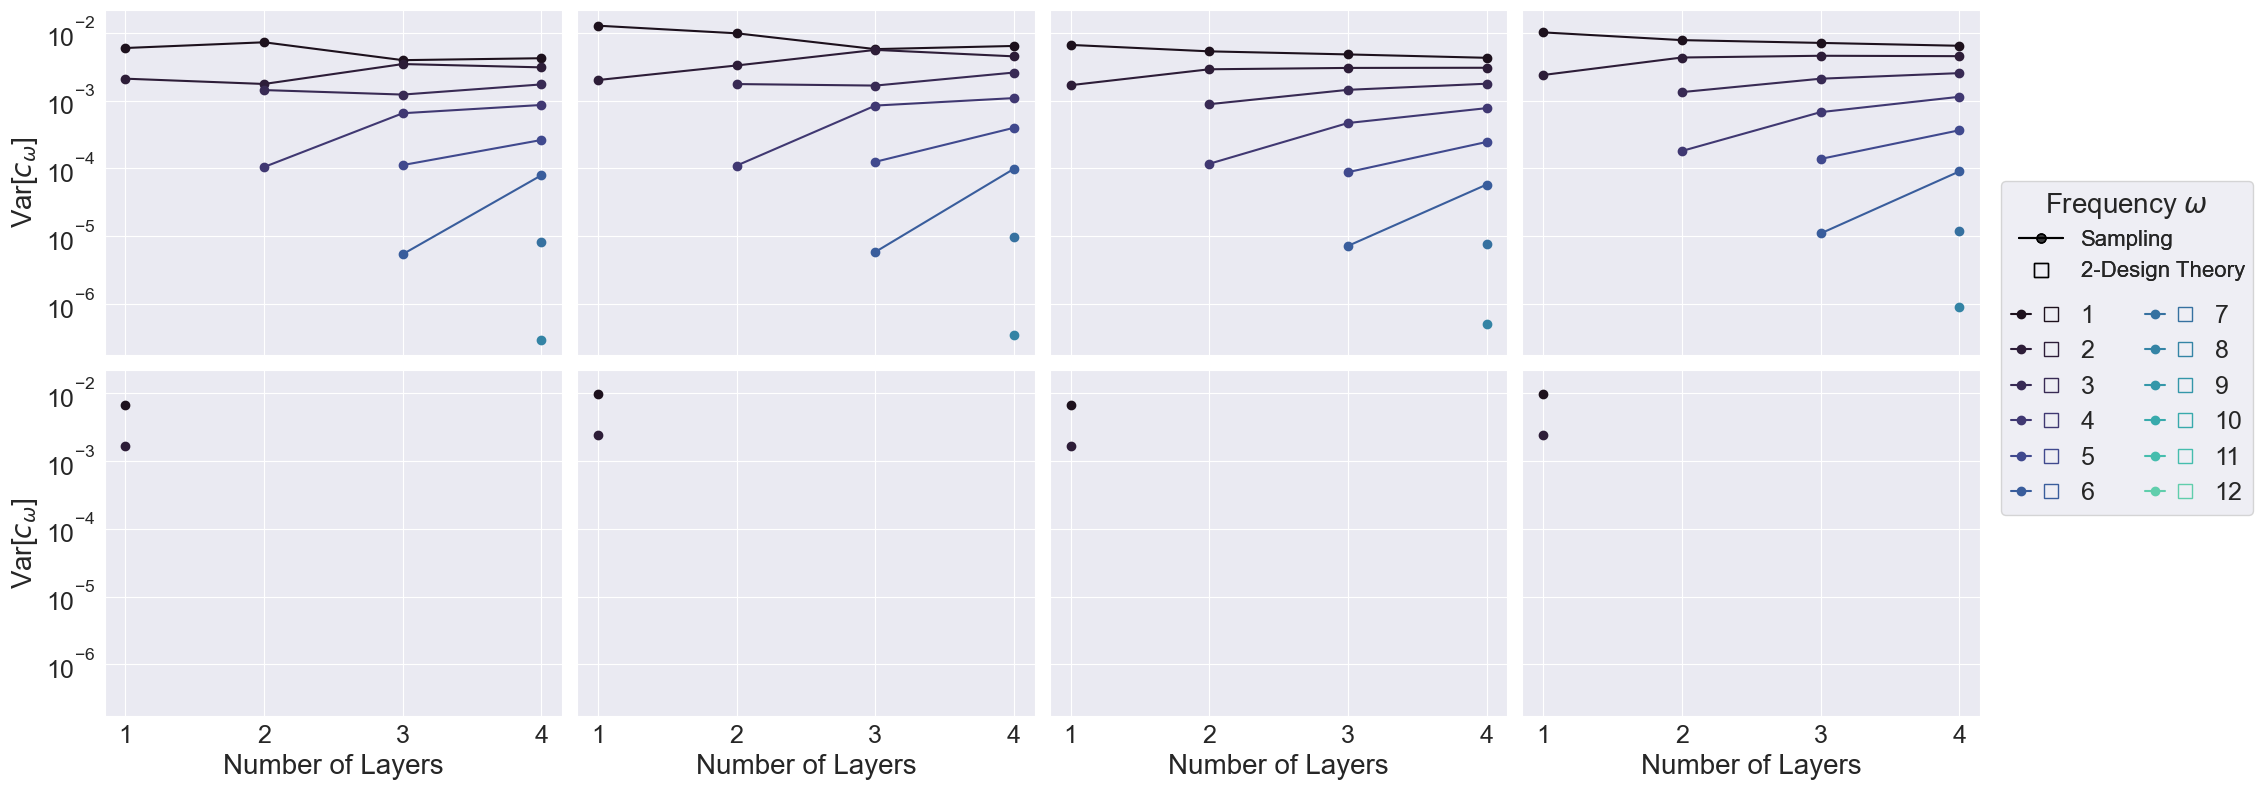

In [7]:
plotting_ansatz = "StronglyEntangling"
qubits =
2
# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex=True,sharey=True)

# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D([], [], color='k', mec=mcolors.to_rgba('k', alpha=1), mfc=mcolors.to_rgba('k', alpha=0.5), marker='o', linestyle='-', linewidth=1.5, markersize=6.5)
unique_theory = mlines.Line2D([], [], color='k', marker='s', linestyle='', markersize=10, markerfacecolor='none')
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {'marker': 'o', 'linewidth': 1.5, 'markersize': 6, 'zorder': 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float('inf'), float('-inf')

# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for row, plotting_n_layers in enumerate([1, 5,10,20]):
    for col, cost_type in enumerate(['local', 'global']):
        ax = axs[row // 2, 2 * (row % 2) + col]
        for freq, color in zip(frequency_range, colors):
            # Select the appropriate data based on layer number and cost type
            data_array = var_dataset['var_coeff'].sel(encoding='pauli_encoding', ansatz=plotting_ansatz, freqs=freq, n_qubits=qubits, n_layers=plotting_n_layers, cost=cost_type)
            #theory_array = var_dataset['var_coeff_theory'].sel(encoding='pauli_encoding', ansatz=plotting_ansatz, freqs=freq, n_qubits=3, n_layers=plotting_n_layers, cost=cost_type)

            # Check if data is above threshold before plotting
            data_above_threshold = data_array.where(data_array > 1e-28, drop=True)
            #theory_above_threshold = theory_array.where(theory_array > 1e-28, drop=True)

            if data_above_threshold.size > 0:
                lines = ax.plot(data_above_threshold['n_circuit_layers'], data_above_threshold, color=color, **plot_settings)
            #if theory_above_threshold.size > 0:
            #    ax.plot(theory_above_threshold['n_layers'], theory_above_threshold, color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none')
    
            # Add legend entries only for the first row and column
            if row == 0 and col == 0:
                legend_handles.append(lines[0])
                square_handles.append(mlines.Line2D([], [], color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none'))
                line_sample = mlines.Line2D([], [], color=color, **plot_settings)
                legend_entries.append((line_sample, square_handles[-1]))

        # Set axis labels and scale
        
        ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=18)
        min_y = min(min_y, ax.get_ylim()[0])
        max_y = max(max_y, ax.get_ylim()[1])
        ax.tick_params(axis='both', which='major', labelsize=18)
        if col == 0 and (row == 0 or row == 2):
            ax.set_ylabel(r"Var[$c_\omega$]", fontsize=20)
        if row == 2 or row == 3:  # Set x-axis labels only for the bottom row
            ax.set_xlabel("Number of Layers", fontsize=20)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 1.135, 0.783
first_legend_labels = ["Sampling","2-Design Theory"]
first_legend = fig.legend([entry for entry in legend_entries[:2]], first_legend_labels, 
                         bbox_to_anchor=(x_legend_loc, y_legend_loc-0.052), fontsize=16, ncols=1,frameon=False)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color='none', marker='none', linestyle='none')
fig.add_artist(first_legend)
handles =[empty_handle,empty_handle]+[entry for entry in legend_entries[2:8]]+ [empty_handle,empty_handle] + [entry for entry in legend_entries[8:]]
legend_labels = ['',''] + [str(freq) for freq in range(1, 7)] + ['',''] + [str(freq) for freq in range(7, 13)]
legend = fig.legend(handles, legend_labels, title=r'Frequency $\omega$',bbox_to_anchor=(x_legend_loc, y_legend_loc),handler_map={tuple: HandlerTuple(None)},title_fontsize=20,fontsize=18,ncols=2)
first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()
plt.savefig('var_coeff.pdf',bbox_inches='tight')
# Show the plot
plt.show()


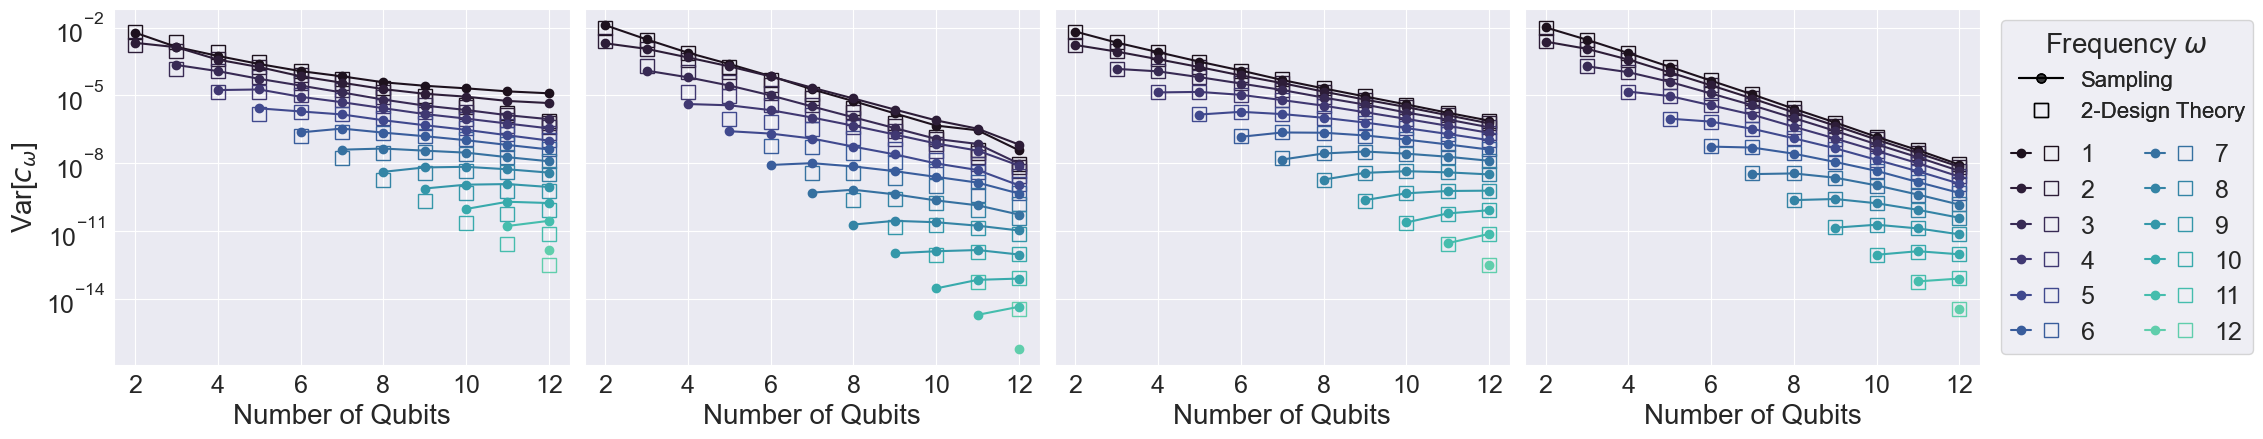

In [6]:
plotting_ansatz = "StronglyEntangling"

# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(1, 4, figsize=(20, 4.5), sharex=True, sharey=True)
# Flatten axs for easier indexing
axs = axs.flatten()

# Define the layers and cost types to plot
layers_list = [1, 5]
cost_types = ["local", "global"]
# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=1),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=6.5,
)
unique_theory = mlines.Line2D(
    [], [], color="k", marker="s", linestyle="", markersize=10, markerfacecolor="none"
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float("inf"), float("-inf")

# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for i, (plotting_n_layers, cost_type) in enumerate(
    itertools.product(layers_list, cost_types)
):
    ax = axs[i]
    for freq, color in zip(frequency_range, colors):
        # Select the appropriate data based on layer number and cost type
        data_array = var_dataset["var_coeff"].sel(
            encoding="pauli_encoding",
            ansatz=plotting_ansatz,
            freqs=freq,
            n_circuit_layers=1,
            n_layers=plotting_n_layers,
            cost=cost_type,
        )
        theory_array = var_dataset["var_coeff_theory"].sel(
            encoding="pauli_encoding",
            ansatz=plotting_ansatz,
            freqs=freq,
            n_circuit_layers=1,
            n_layers=plotting_n_layers,
            cost=cost_type,
        )

        # Plot the data and theory arrays
        # lines = ax.plot(data_array['n_qubits'], data_array, color=color, **plot_settings)
        # ax.plot(theory_array['n_qubits'], theory_array, color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none')
        # Check if data is above threshold before plotting
        data_above_threshold = data_array.where(data_array > 1e-28, drop=True)
        theory_above_threshold = theory_array.where(theory_array > 1e-28, drop=True)

        if data_above_threshold.size > 0:
            ax.plot(
                data_above_threshold["n_qubits"],
                data_above_threshold,
                color=color,
                **plot_settings
            )
        if theory_above_threshold.size > 0:
            ax.plot(
                theory_above_threshold["n_qubits"],
                theory_above_threshold,
                color=color,
                marker="s",
                linestyle="",
                markersize=10,
                markerfacecolor="none",
            )

        # Add legend entries only for the first row and column
        if i == 0:
            legend_handles.append(lines[0])
            square_handles.append(
                mlines.Line2D(
                    [],
                    [],
                    color=color,
                    marker="s",
                    linestyle="",
                    markersize=10,
                    markerfacecolor="none",
                )
            )
            line_sample = mlines.Line2D([], [], color=color, **plot_settings)
            legend_entries.append((line_sample, square_handles[-1]))

    # Set axis labels and scale
    ax.set_yscale("log")
    ax.tick_params(axis="both", which="major", labelsize=18)
    min_y = min(min_y, ax.get_ylim()[0])
    max_y = max(max_y, ax.get_ylim()[1])
    ax.tick_params(axis="both", which="major", labelsize=18)
    if i == 0:
        ax.set_ylabel(r"Var[$c_\omega$]", fontsize=20)
    ax.set_xlabel("Number of Qubits", fontsize=20)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 1.135, 0.97
first_legend_labels = ["Sampling", "2-Design Theory"]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc, y_legend_loc - 0.095),
    fontsize=16,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"Frequency $\omega$",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=20,
    fontsize=18,
    ncols=2,
)
first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()
plt.savefig("var_coeff.pdf", bbox_inches="tight")
# Show the plot
plt.show()